In [1]:
import os
import h5py
import mahotas as mh
import numpy as np

from skimage import measure
from stl import mesh



import matplotlib as plt
from matplotlib.pyplot import imshow
%matplotlib inline

/home/d/nolearn/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [8]:
DATA = '/home/d/data/ac3x75/mojo/ids/tiles/w=00000000/'


In [5]:
def threshold(arr, val):
    out = np.zeros((arr.shape[0], arr.shape[1]), dtype=np.bool)
    out[arr == val] = 1
    return out

In [19]:
def store_mesh(arr, filename):
    
    verts, faces = measure.marching_cubes(arr, 0, spacing=(10.,1.,1.),gradient_direction='ascent')
    applied_verts = verts[faces]
    
    mesh_data = np.zeros(applied_verts.shape[0], dtype=mesh.Mesh.dtype)
    
    print 'Converting', applied_verts.shape[0], 'vertices'
    for i, v in enumerate(applied_verts):
        mesh_data[i][1][0] = v[0]
        mesh_data[i][1][1] = v[1]
        mesh_data[i][1][2] = v[2]
        
    m = mesh.Mesh(mesh_data)
    with open(filename, 'w') as f:
        m.save(filename, f)
        
    print 'Saved.'
    
    return m

In [11]:
NEURON_ID = 3036
# X_SHAPE = 8192
# Y_SHAPE = 8192
X_SHAPE=1024
Y_SHAPE=1024
Z_SHAPE = (0,75)

thresholded_3d = np.zeros((Z_SHAPE[1], Y_SHAPE, X_SHAPE), dtype=np.bool)
# threed = np.zeros((Z_SHAPE[1], Y_SHAPE, X_SHAPE), dtype=np.uint64)


for SLICE in range(Z_SHAPE[0], Z_SHAPE[1]):

    img = np.zeros((Y_SHAPE,X_SHAPE), dtype=np.uint64)
    tiles = sorted(os.listdir(os.path.join(DATA, 'z='+str(SLICE).zfill(8))))
    
    
    for t in tiles:
        
        if t.startswith('.'):
            continue
        
        filepath = os.path.join(DATA, 'z='+str(SLICE).zfill(8), t)
        y = int(t.split(',')[0].split('=')[1])
        x = int(t.split(',')[1].split('=')[1].split('.')[0])
        with h5py.File(filepath, 'r') as f:
            data = f.get('IdMap')
            img[y*512:y*512+512, x*512:x*512+512] = data

    # now threshold this bad boy
    thresholded_slice = threshold(img, NEURON_ID)
    thresholded_3d[SLICE] = thresholded_slice
#     threed[SLICE] = img
    
    print 'loaded', SLICE
            

loaded 0
loaded 1
loaded 2
loaded 3
loaded 4
loaded 5
loaded 6
loaded 7
loaded 8
loaded 9
loaded 10
loaded 11
loaded 12
loaded 13
loaded 14
loaded 15
loaded 16
loaded 17
loaded 18
loaded 19
loaded 20
loaded 21
loaded 22
loaded 23
loaded 24
loaded 25
loaded 26
loaded 27
loaded 28
loaded 29
loaded 30
loaded 31
loaded 32
loaded 33
loaded 34
loaded 35
loaded 36
loaded 37
loaded 38
loaded 39
loaded 40
loaded 41
loaded 42
loaded 43
loaded 44
loaded 45
loaded 46
loaded 47
loaded 48
loaded 49
loaded 50
loaded 51
loaded 52
loaded 53
loaded 54
loaded 55
loaded 56
loaded 57
loaded 58
loaded 59
loaded 60
loaded 61
loaded 62
loaded 63
loaded 64
loaded 65
loaded 66
loaded 67
loaded 68
loaded 69
loaded 70
loaded 71
loaded 72
loaded 73
loaded 74


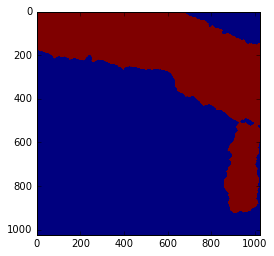

In [12]:
imshow(thresholded_3d[0])

In [16]:
m1 = store_mesh(thresholded_3d, '/home/d/data/neurons/'+str(NEURON_ID)+'.stl')

Converting 1119246 vertices
Saved.


In [20]:
m1 = store_mesh(thresholded_3d, '/home/d/data/neurons/'+str(NEURON_ID)+'.stl')

Converting 1119246 vertices
Saved.


In [47]:
from mpl_toolkits import mplot3d
from matplotlib import pyplot

In [ ]:

# Create a new plot
figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)

# Load the STL files and add the vectors to the plot
# your_mesh = mesh.Mesh.from_file('tests/stl_binary/HalfDonut.stl')
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(m1.vectors))

# Auto scale to the mesh size
scale = m1.points.flatten(-1)
axes.auto_scale_xyz(scale, scale, scale)

# Show the plot to the screen
pyplot.show()

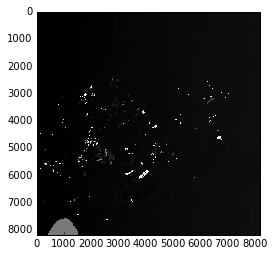

In [23]:
imshow(img, cmap='gray')

In [26]:
img[4500,2700]

55260

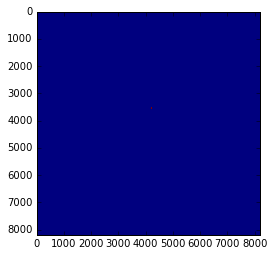

In [35]:
imshow(thresholded_3d[80])

In [29]:
threshold(img, 55260).nbytes

67108864

In [30]:
img.nbytes

536870912

In [39]:
mh.labeled.bbox(thresholded_3d)

array([[   0,   36,    0, 8192,    0, 8192],
       [   0,   36, 1842, 7615, 1256, 4333]])

In [40]:
bb = [   0,   36, 1842, 7615, 1256, 4333]

In [41]:
cropped_3d = thresholded_3d[bb[0]:bb[1], bb[2]:bb[3], bb[4]:bb[5]]

In [44]:
store_mesh(cropped_3d, '/home/d/data/neurons/'+str(NEURON_ID)+'.stl')

Converting 16404281 vertices
Saved.


In [48]:
store_mesh(thresholded_3d, '/home/d/data/neurons/'+str(NEURON_ID)+'_512.stl')

Converting 572743 vertices
Saved.


In [6]:
import nibabel as nib

In [12]:
affine = np.diag([1, 1, 1, 1])
a_i = nib.Nifti1Image(thresholded_3d.astype(np.uint8), affine)

In [13]:
nib.save(a_i, '/tmp/out2.nii')

In [10]:
thresholded_3d.shape

(700, 512, 512)

In [15]:
affine = np.diag([1, 1, 1, 1])
a_i = nib.Nifti1Image(threed, affine)

In [16]:
nib.save(a_i, '/tmp/out3.nii')

In [40]:
h = mh.fullhistogram(threed)

In [41]:
large_segments = np.where(h>10000)[0]
seg_255 = large_segments[-255:]
threed_8bit = np.zeros((threed.shape[0], threed.shape[1], threed.shape[2]), dtype=np.uint8)

for i,s in enumerate(seg_255):
    threed_8bit[threed==s] = i

In [42]:
affine = np.diag([1, 1, 1, 1])
a_i = nib.Nifti1Image(threed_8bit[:,0:1000,0:1000], affine)
nib.save(a_i, '/tmp/out8bit_small.nii')